In [45]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

In [46]:
# Ładowanie danych
pima = pd.read_csv('Data/diabetes.csv', sep=';')
df = pd.read_csv('Data/diabetes_pt1.csv', sep=';')
df_test = pd.read_csv('Data/diabetes_pt2.csv', sep=';')

In [47]:
# Definiowanie kolumn z danymi
feature_columns = ['Glucose', 'BMI', 'Age']

# Przygotowanie danych dla modelu Stan
stan2_data = {
    'N': len(df),
    'X': df[feature_columns].values,
    'y': df['Outcome'].values
}
test2_data = {
    'N': len(df_test),
    'X': df_test[feature_columns].values,
    'y': df_test['Outcome'].values
}

In [48]:
# Kompilacja i próbkowanie modelu
sm2 = CmdStanModel(stan_file='Stan/code_1.stan')
fit2 = sm2.sample(data=stan2_data, iter_sampling=2000, chains=4, iter_warmup=2000, seed=210800)

INFO:cmdstanpy:compiling stan file /GA/Data-Analytics/Project/PimaDiabetesPrediction/LogisticRegresion/Stan/code_1.stan to exe file /GA/Data-Analytics/Project/PimaDiabetesPrediction/LogisticRegresion/Stan/code_1


INFO:cmdstanpy:compiled model executable: /GA/Data-Analytics/Project/PimaDiabetesPrediction/LogisticRegresion/Stan/code_1
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)
chain 1 |█▋        | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)

chain 1 |██▍       | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |██▊       | 00:00 Iteration: 1000 / 4000 [ 25%]  (Warmup)


chain 1 |███▎      | 00:00 Iteration: 1200 / 4000 [ 30%]  (Warmup)


chain 1 |████      | 00:00 Iteration: 1500 / 4000 [ 37%]  (Warmup)




chain 1 |████▊     | 00:00 Iteration: 1800 / 4000 [ 45%]  (Warmup)


chain 1 |█████▍    | 00:01 Iteration: 2001 / 4000 [ 50%]  (Sampling)


chain 1 |██████▏   | 00:01 Iteration: 2300 / 4000 [ 57%]  (Sampling)


chain 1 |██████▋   | 00:01 Iteration: 2500 / 4000 [ 62%]  (Sampling)


chain 1 |███████▏  | 00:01 Iteration: 2700 / 4000 [ 67%]  (Sampling)


chain 1 |███████▌  | 00:01 Iterat


INFO:cmdstanpy:CmdStan done processing.


In [49]:
# Obliczenie średnich estymowanych parametrów
betas = ['glucose', 'bmi', 'age']

df3 = fit2.draws_pd()
alpha_mean = df3['alpha'].mean()
beta_means = [df3[f'beta_{name}'].mean() for name in betas]

In [50]:
# Obliczenie prawdopodobieństw na podstawie modelu
logit_preds_test = alpha_mean + np.dot(test2_data['X'], beta_means)
probs_test2 = 1 / (1 + np.exp(-logit_preds_test))


In [51]:
# Konwersja prawdopodobieństw do przewidywanych klas
preds_test2 = (probs_test2 > 0.5).astype(int)

In [52]:
# Obliczanie metryk
accuracy = accuracy_score(test2_data['y'], preds_test2)
precision = precision_score(test2_data['y'], preds_test2)
recall = recall_score(test2_data['y'], preds_test2)
f1 = f1_score(test2_data['y'], preds_test2)

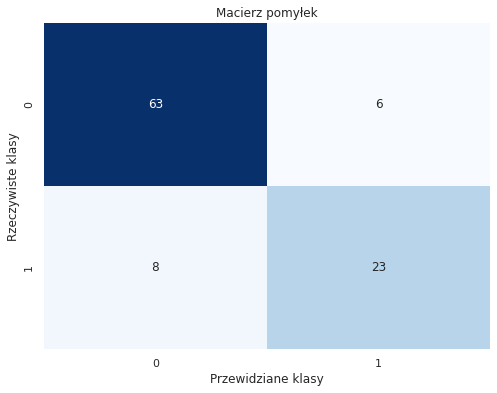

In [53]:
# Macierz pomyłek
conf_matrix = confusion_matrix(test2_data['y'], preds_test2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziane klasy')
plt.ylabel('Rzeczywiste klasy')
plt.show()


In [54]:
# Krzywa ROC i obliczenie AUC
fpr, tpr, _ = roc_curve(test2_data['y'], probs_test2)
roc_auc = auc(fpr, tpr)

# Wyświetlanie wyników
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.86
Precision: 0.79
Recall: 0.74
F1 Score: 0.77


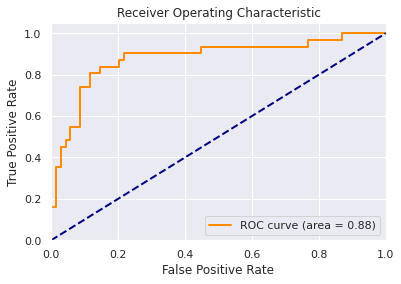

In [55]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()